# Workspace \#3: ``astro.py``

In [3]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
# %matplotlib inline
%matplotlib notebook

%config InlineBackend.figure_format = "retina"
#rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap

/home/chen/Code/axion_laser/github/workspace_notebooks/../constants.py:51: RuntimeWarning: divide by zero encountered in true_divide
  B_eff = 2.*r / np.sqrt(number_of_tel)


In [5]:
# The contents of astro.py
dir(ap)

['AdiabaticErrorMssg',
 'ED_fn',
 'FreeErrorMssg',
 'Galactic',
 'HEALPix',
 'L_adiab',
 'L_eff',
 'L_free',
 'L_source',
 'L_thy',
 'P_noise',
 'P_signal',
 'Rb_TM99',
 'SKA_exper_nu',
 'SKA_get_active_baseline',
 'SKA_specs',
 'ST_fn',
 'S_cygA',
 'SkyCoord',
 'Snu_supp',
 'T_noise',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'alpha_from_gamma',
 'bg_408_temp',
 'ct',
 'dimless_adiab',
 'dimless_free',
 'dimless_lum',
 'division',
 'erf',
 'exp',
 'flux',
 'flux_density_to_psd',
 'fsolve',
 'ftt',
 'gamma_from_alpha',
 'getargspec',
 'hp',
 'irrad',
 'lambertw',
 'log',
 'log10',
 'map_allsky_408',
 'model_age',
 'np',
 'nu_factor',
 'os',
 'pars_always',
 'pars_early',
 'pars_late',
 'pars_lightcurve',
 'pars_required',
 'path',
 'pi',
 'power',
 'psd_to_flux_density',
 'pt',
 'r_to_gal',
 'rho_MW',
 'rho_NFW',
 'sandwich_logeqn',
 'source_id',
 'source_input',
 'sqrt',
 't_arr_default',
 'tage_compute',
 'theta

In [6]:
# parameters required for each astro model. The keys are of the form (model, missing_parameter), for a fixed lightcurve model ('eff'/'thy') and a given missing parameter. The values are then the parameters that need to be known and passed in order to compute the lightcurve. Essentially, the missing parameter is computed based on all the others.

ap.pars_required

{('eff', 'L_today'): ['L_peak', 't_peak', 'gamma', 't_trans', 't_age'],
 ('eff', 'L_peak'): ['t_peak', 'gamma', 't_trans', 't_age', 'L_today'],
 ('eff', 't_age'): ['L_peak', 't_peak', 'gamma', 't_trans', 'L_today'],
 ('eff', 't_trans'): ['L_peak', 't_peak', 'gamma', 'L_today', 't_age'],
 ('thy', 'L_today'): ['L_norm',
  'K2',
  'beta',
  'delta',
  't_trans',
  'gamma',
  't_age'],
 ('thy', 'L_norm'): ['K2',
  'beta',
  'delta',
  't_trans',
  'gamma',
  't_age',
  'L_today']}

## **NOTA BENE:**

### When using either of the spectral luminosities (at peak day, $L_{\rm peak, \, \nu}$; and today, $L_{\rm today, \, \nu}$) to compute the lightcurve, make sure they are evaluated **at the same frequency $\nu$, which _must_ be the pivot frequency $\nu_{\rm pivot}$**. Otherwise, the lighcturve is inconsistent.

Testing that different approaches to the lightcurve models give the same results:

## 1. Lightcurve

### 1.1 Exact (numeric)

In [5]:
# compute lightcurve for different models and approaches
t_peak = 100. # [days] # DO NOT CHANGE IN ORDER TO COMPARE
t_age = 300. # [years]
t_trans = 1. # [years] # DO NOT CHANGE IN ORDER TO COMPARE
t_arr = np.array([t_peak/365., t_trans, t_age]) # [years]

# doing 'eff'

L_peak = 1.e28

source_input = []
approach = []

approach.append('missing L_today')
source_input.append(('eff', {'L_peak':L_peak, 't_peak':t_peak, 'gamma':1., 't_trans':t_trans, 't_age':t_age}))

L_today = ap.L_source(t=t_age,
                      model=source_input[0][0],
                      output_pars=False,
                      **source_input[0][1])

approach.append('missing L_peak')
source_input.append(('eff', {'L_today':L_today, 't_age':t_age, 't_peak':t_peak, 'gamma':1., 't_trans':t_trans, 't_age':t_age}))

approach.append('missing t_trans')
source_input.append(('eff', {'L_today':L_today, 'L_peak':L_peak, 't_age':t_age, 't_peak':t_peak, 'gamma':1.}))

approach.append('missing t_age')
source_input.append(('eff', {'L_today':L_today, 'L_peak':L_peak, 't_trans':t_trans, 't_peak':t_peak, 'gamma':1.}))

print("------------------\nMODEL: 'eff'\n------------------\n")

L_fns = {}
for i, val in enumerate(source_input):
    
    model = val[0]
    pars = val[1]
    
    print(approach[i]+':')
    print(val)
    print('\n(time, Lum): %s' %([(t, ap.L_source(t=t,
                                           model=model,
                                           output_pars=False,
                                           **pars)) for t in t_arr]))
    print('pars: %s\n..................\n' %(ap.L_source(t=t_age,
                                model=model,
                                output_pars=True, **pars)[-1]))


# doing 'thy'
t_check = t_peak # [days]
t_arr = np.array([t_check/365., t_trans, t_age]) # [years]

K2 = 2.4e3 # DO NOT CHANGE IN ORDER TO COMPARE

print("\n------------------\nMODEL: 'thy'\n------------------\n")

approach.append('missing L_norm')
source_input.append(('thy', {'L_today':L_today, 't_age':t_age, 'beta':0.64, 'K2':K2, 'delta':2.82, 'gamma':1., 't_trans':t_trans, 'tau_factor':((1./5.)**-2.1)}))

L_norm = 1.8672956e+29 * (L_today/1.4203781639864318e+25) # DO NOT CHANGE IN ORDER TO COMPARE

approach.append('missing L_today')
source_input.append(('thy', {'L_norm':L_norm, 'beta':0.64, 'K2':K2, 'delta':2.82, 'gamma':1., 't_trans':t_trans, 't_age':t_age, 'tau_factor':((1./5.)**-2.1)}))

for i, val in enumerate(source_input):
    
    model = val[0]
    pars = val[1]
    
    if model != 'thy':
        continue
    
    print(approach[i]+':')
    print(val)
    print('\n(time, Lum):%s' %([(t, ap.L_source(t=t,
                                           model=model,
                                           output_pars=False,
                                           **pars)) for t in t_arr]))
    print('pars: %s\n..................\n' %(ap.L_source(t=t_age,
                                model=model,
                                output_pars=True,
                                **pars)[-1]))

------------------
MODEL: 'eff'
------------------

missing L_today:
('eff', {'t_trans': 1.0, 't_peak': 100.0, 'L_peak': 1e+28, 't_age': 300.0, 'gamma': 1.0})

(time, Lum): [(0.273972602739726, 1e+28), (1.0, 4.261134491959295e+27), (300.0, 1.4203781639864318e+25)]
pars: {'L_peak': 1e+28, 'L_ref': 4.261134491959295e+27, 't_trans': 1.0, 'L_today': 1.4203781639864318e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 1.0, 't_ref': 1.0}
..................

missing L_peak:
('eff', {'t_trans': 1.0, 'L_today': 1.4203781639864318e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 1.0})

(time, Lum): [(0.273972602739726, 1e+28), (1.0, 4.261134491959295e+27), (300.0, 1.4203781639864318e+25)]
pars: {'L_peak': array(1.e+28), 'L_ref': 1.4203781639864318e+25, 't_trans': 1.0, 'L_today': 1.4203781639864318e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 1.0, 't_ref': 300.0}
..................

missing t_trans:
('eff', {'t_peak': 100.0, 'L_today': 1.4203781639864318e+25, 'L_peak': 1e+28, 't_age': 300.0, 'gamma'

Comparing the lightcuarves from different approaches:

/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


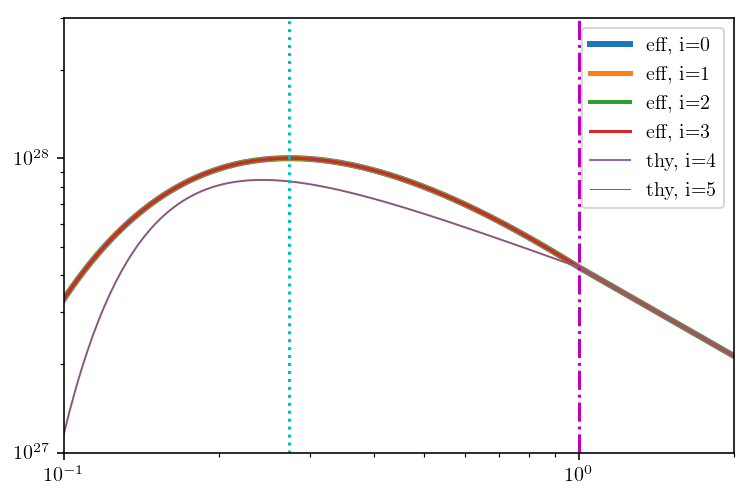

In [6]:
t_arr = np.logspace(log10(1./365), log10(t_age)+0.5, 1001)

max_w = len(source_input)*.5
for i, mod_pars in enumerate(source_input):
    
    model, params = mod_pars
    
    Lfn = lambda tt: ap.L_source(t=tt, model=model, output_pars=False, **params)
    
    plt.loglog(t_arr, Lfn(t_arr), label="{}, i={}".format(model, i), lw=max_w-0.5*i)

plt.axvline(t_age, ls='-', color='k')
plt.axvline(t_trans, ls='-.', color='m')
plt.axvline(t_peak/365, ls=':', color='c')

plt.xlim(0.1, 2.);plt.ylim(1.e27, 3.e28);
# plt.ylim(1.e20, 1.e30);
plt.legend();

Yet another example of lightcurve comparison: Cassiopeia A

{'L_peak': 1e+30, 'L_ref': 3.4107475979735767e+27, 't_trans': 32.59251578474538, 'L_today': 3.7663679059960575e+25, 't_peak': 100.0, 't_age': 300.0, 'gamma': 2.03, 't_ref': 32.59251578474538}
(1001,) (1001,)


True

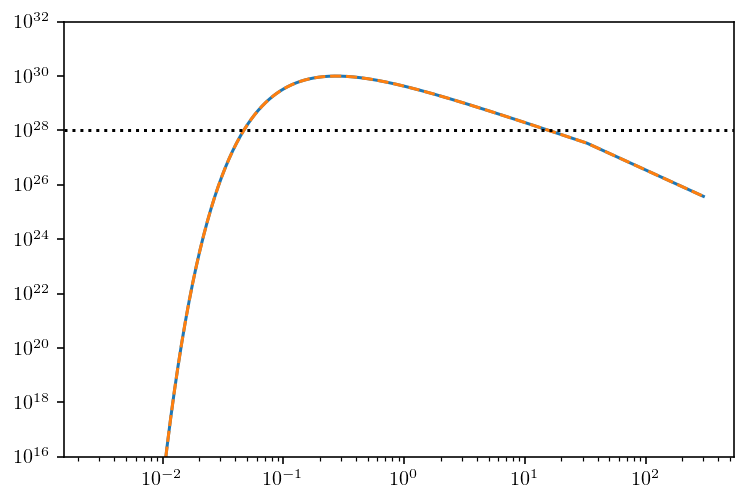

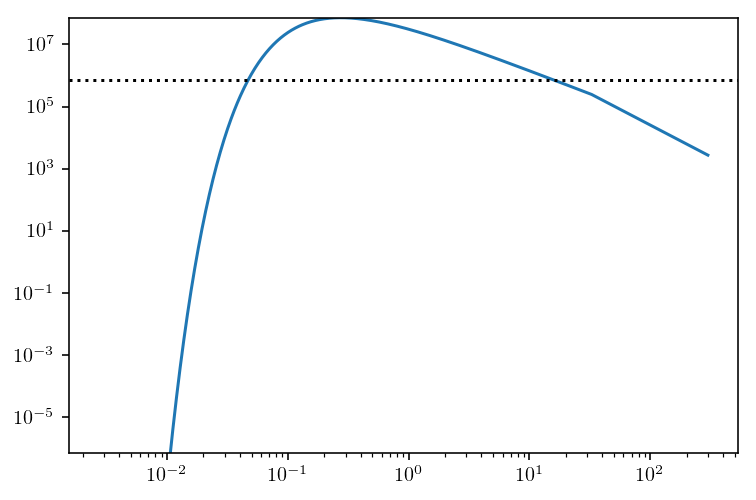

In [7]:
# Cassiopeia A lightcurve

output={}

D = 3.4 # [kpc] Cas A
A = 4.*pi*(D*ct._kpc_over_cm_)**2. # [cm^2] area
SnuCasA = 2723 # [Jy] Cas A

LumCasA = (SnuCasA*ct._Jy_over_cgs_irrad_)*A

source_input = {'longitude':111.734745, # Cas A
                'latitude':-02.129570, # Cas A
                'distance':D, # Cas A
                'size':1.e-6,
                't_age':300., # Cas A
                'alpha':0.77,
                'nu_pivot':1.,
                'gamma':2.03, # Cas A experiment
                'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                't_peak':100.
               }

import echo as ec # temporarily, just to check with the spectral irradiance function in that module
ec.check_source(source_input)

t_arr = np.logspace(log10(1./365), log10(source_input['t_age']), 1001)
t_ref = 1.
nu_arr = np.logspace(-4, 1, 1001)

_, pars = ap.L_source(t_ref,
                      output_pars=True,
                      **source_input)
print(pars)

t, nu = t_arr, 1.
fac = ap.nu_factor(nu, source_input['nu_pivot'], source_input['alpha'])

Lnu = ap.L_source(t, output_pars=False, **source_input)**fac

Snu = ec.Snu_source(t, nu, source_input, output=output)

print('%s %s' %(Snu.shape, Lnu.shape))

fig_num = int(random()*100)
Area = 4.*pi*(source_input['distance']*ct._kpc_over_cm_)**2.

plt.figure(fig_num)
plt.loglog(t_arr, (Snu*ct._Jy_over_cgs_irrad_)*Area)
plt.loglog(t_arr, Lnu, ls='--')
plt.ylim(1.e16, 1.e32);
plt.axhline(1.e28, c='k', ls=':')

fig_num += 1
plt.figure(fig_num)
plt.loglog(t_arr, Snu)
plt.ylim(1.e16 /(Area*ct._Jy_over_cgs_irrad_), 1.e30 /(Area*ct._Jy_over_cgs_irrad_));
plt.axhline(1.e28 /(Area*ct._Jy_over_cgs_irrad_), c='k', ls=':')

# updating data
ec.Snu_source(t_arr, nu_arr, source_input, output=output)
'source_t-nu-Snu' in output.keys()

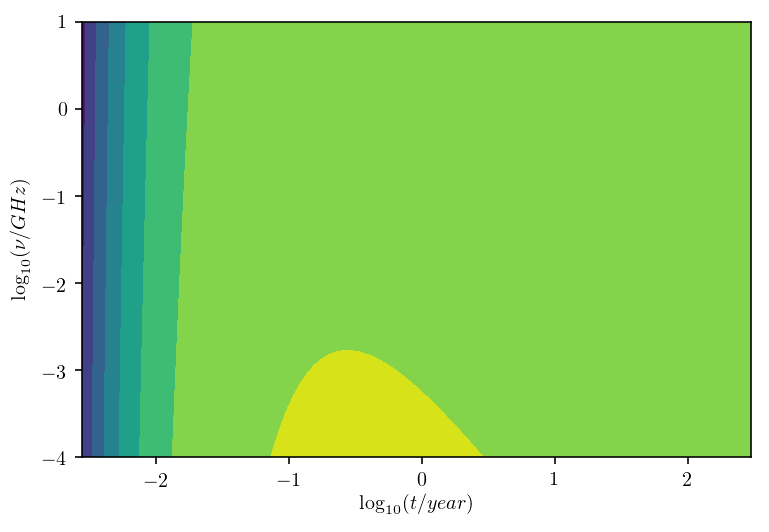

In [8]:
tArr, nuArr, SnuGr = output['source_t-nu-Snu']

plt.contourf(log10(tArr), log10(nuArr), log10(SnuGr))
plt.xlabel(r'$\log_{10}(t/year)$');plt.ylabel(r'$\log_{10}(\nu/GHz)$');

In [ ]:
# more tests

<IPython.core.display.Javascript object>


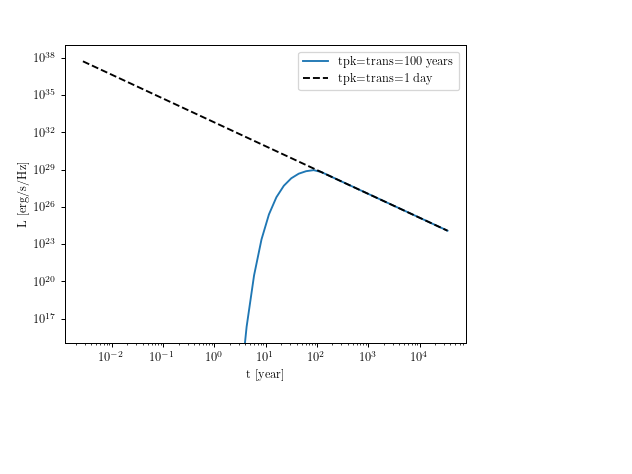

In [14]:
plt.subplots()
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e15, 1e39)
plt.xlabel('t [year]')
plt.ylabel('L [erg/s/Hz]')


longitude = 6.4 #175 #175 #178 #10 #179 # 111.734745
latitude = -0.1 # -02.129570
D = 1.8 #0.5 #[kpc]
alpha = 0.7
gamma = ap.gamma_from_alpha(alpha)
t_peak = 100.*365  #100 * 365
t_trans = t_peak /365
t_age = 35000
S0 = 310 #Jy
L_today = S0 * ct._Jy_over_cgs_irrad_ * 4.*np.pi * (D*ct._kpc_over_cm_)**2
ang_size = 1.5e-4 #None #1.5e-4#None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #

source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, # Cas A experiment
                'model': "eff", 'L_today': L_today, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True
               }

t_arr = np.logspace(np.log10(1./365), np.log10(source_input['t_age']))
L_arr = ap.L_source(t_arr, **source_input)
plt.plot(t_arr, L_arr, label='tpk=trans=100 years')

t_peak = 1. 
t_trans = t_peak /365
t_age = 35000-100
source_input['t_peak'] = t_peak
source_input['t_trans'] = t_trans
source_input['t_age'] = t_age
t_arr = np.logspace(np.log10(t_peak/365), np.log10(source_input['t_age']))
L_arr = ap.L_source(t_arr, **source_input)
plt.plot(t_arr, L_arr, 'k--', label='tpk=trans=1 day')


# t_peak = 1. 
# t_trans = t_peak /365
# t_age = 35000*(1./(100.*365))
# source_input['t_peak'] = t_peak
# source_input['t_trans'] = t_trans
# source_input['t_age'] = t_age
# t_arr = np.logspace(np.log10(t_peak/365), np.log10(source_input['t_age']))
# L_arr = ap.L_source(t_arr, **source_input)
# plt.plot(t_arr, L_arr, 'r:', label='tpk=trans=1 day, shifted')

plt.legend(loc='best')

In [13]:
t_age

0.9589041095890412

### 1.2 Analytic

``astro.py`` also containts analytic formulas for the lightcurve.

In [9]:
help(ap.Snu_supp)

Help on function Snu_supp in module astro:

Snu_supp(gamma, frac_tpk, frac_tt)
    Fractional suppression of spectral irradiance (i.e. S0/S_peak = L0/L_peak).
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    frac_tt : ratio of transition time to SNR age



In [10]:
help(ap.ftt)

Help on function ftt in module astro:

ftt(gamma, frac_tpk, sup)
    Fractional transition time (i.e. t_trans/t_age).
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    sup : spectral irradiance suppression



In [11]:
help(ap.dimless_free)

Help on function dimless_free in module astro:

dimless_free(frac_tpk, tau)
    Dimensionless free expansion lightcurve.
    
    Parameters
    ----------
    frac_tpk : ratio of peak day to SNR age
    tau : ratio of time to SNR age



In [12]:
help(ap.dimless_adiab)

Help on function dimless_adiab in module astro:

dimless_adiab(gamma, sup, tau)
    Dimensionless adiabatic expansion lightcurve.
    
    Parameters
    ----------
    gamma : adiabatic index
    sup : spectral irradiance suppression
    tau : ratio of time to SNR age



In [13]:
help(ap.dimless_lum)

Help on function dimless_lum in module astro:

dimless_lum(gamma, frac_tpk, sup, tau)
    Dimensionless full lightcurve.
    
    Parameters
    ----------
    gamma : adiabatic index
    frac_tpk : ratio of peak day to SNR age
    sup : spectral irradiance suppression
    tau : ratio of time to SNR age



## 2. Experiment

In [14]:
help(ap.SKA_exper_nu)

Help on function SKA_exper_nu in module astro:

SKA_exper_nu(nu)
    Returns the SKA experiment mode (low/mid) sensitive to the given frequency nu [GHz].
    
    Parameters
    ----------
    nu : frequency [GHz]



In [15]:
print(ap.SKA_exper_nu(ct._nu_min_ska_low_*0.9))
print('%s %s' %(ap.SKA_exper_nu(ct._nu_min_ska_low_*1.1), ap.SKA_exper_nu(ct._nu_max_ska_low_*0.9)))
print('%s %s' %(ap.SKA_exper_nu(ct._nu_min_ska_mid_*1.1), ap.SKA_exper_nu(ct._nu_max_ska_mid_*0.9)))
print(ap.SKA_exper_nu(ct._nu_max_ska_mid_*1.1))

None
SKA low SKA low
SKA mid SKA mid
None


In [16]:
help(ap.SKA_specs)

Help on function SKA_specs in module astro:

SKA_specs(nu, exper_mode, eta=0.8)
    Returns the specifications (area [m^2], window, receiver noise brightness temperature [K], and solid angle resolution [sr]) of the SKA experiment mode, for the given frequency [GHz].
    
    Parameters
    ----------
    nu : frequency [GHz]
    exper_mode : mode in which the experiment is working
    eta: the detector efficiency (default: 0.8)



In [17]:
print(ap.SKA_specs(ct._nu_min_ska_low_*1.1, 'SKA low')) # within SKA low detection region
print(ap.SKA_specs(ct._nu_min_ska_mid_*1.1, 'SKA mid')) # within SKA mid detection region
print(ap.SKA_specs(ct._nu_min_ska_mid_*1.1, 'SKA low')) # outside SKA low detection region

(419000.0, 1.0, 40.0, 5.688417552775966e-05)
(1000000.0, 1.0, 20.0, 4.864184734749385e-07)
(419000.0, 0.0, 40.0, 1.1609032572290805e-06)


In [3]:
Nma = 101
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

In [5]:
ap.SKA_specs(nulow, 'SKA low')[-1]

array([6.88298306e-05, 6.35745015e-05, 5.87204293e-05, 5.42369771e-05,
       5.00958473e-05, 4.62709027e-05, 4.27380021e-05, 3.94748470e-05,
       3.64608419e-05, 3.36769636e-05, 3.11056413e-05, 2.87306459e-05,
       2.65369873e-05, 2.45108201e-05, 2.26393559e-05, 2.09107827e-05,
       1.93141905e-05, 1.78395021e-05, 1.64774100e-05, 1.52193171e-05,
       1.40572828e-05, 1.29839727e-05, 1.19926127e-05, 1.10769456e-05,
       1.02311920e-05, 9.45001387e-06, 8.72848071e-06, 8.06203848e-06,
       7.44648084e-06, 6.87792262e-06, 6.35277529e-06, 5.86772432e-06,
       5.41970826e-06, 5.00589939e-06, 4.62368590e-06, 4.27065540e-06,
       3.94457971e-06, 3.64340074e-06, 3.36521757e-06, 3.10827441e-06,
       2.87094953e-06, 2.65174503e-06, 2.44927736e-06, 2.26226863e-06,
       2.08953850e-06, 1.92999677e-06, 1.78263646e-06, 1.64652750e-06,
       1.52081082e-06, 1.40469293e-06])

In [6]:
ap.SKA_specs(numid, 'SKA mid')[-1]

array([5.88566351e-07, 5.05891432e-07, 4.34829717e-07, 3.73749922e-07,
       3.21249903e-07, 2.76124472e-07, 2.37337734e-07, 2.03999304e-07,
       1.75343866e-07, 1.50713610e-07, 1.29543123e-07, 1.11346420e-07,
       9.57057764e-08, 8.22621479e-08, 7.07069226e-08, 6.07748411e-08,
       5.22379014e-08, 4.49001320e-08, 3.85930864e-08, 3.31719802e-08,
       2.85123686e-08, 2.45072841e-08, 2.10647872e-08, 1.81058525e-08,
       1.55625539e-08, 1.33765079e-08, 1.14975325e-08, 9.88249382e-09,
       8.49431657e-09, 7.30113420e-09, 6.27555646e-09, 5.39403956e-09,
       4.63634756e-09, 3.98508787e-09, 3.42530939e-09, 2.94416212e-09,
       2.53060067e-09, 2.17513106e-09, 1.86959448e-09, 1.60697542e-09,
       1.38124615e-09, 1.18722509e-09, 1.02045755e-09, 8.77115916e-10,
       7.53908356e-10, 6.48008298e-10, 5.56983999e-10, 4.78744830e-10,
       4.11496633e-10, 3.53694281e-10, 3.04011687e-10])

## 3. Observation

In [18]:
# background brightness temperature at 408 MHz
ap.bg_408_temp(0., 0.)

725.2261352539062

In [19]:
print(ap.T_noise(1., Tr=0.))
print(ap.T_noise(1., Tr=10.*np.ones(5)))

8.47053053656
[18.47053054 18.47053054 18.47053054 18.47053054 18.47053054]


In [20]:
help(ap.P_noise)

Help on function P_noise in module astro:

P_noise(T_noise, delnu, tobs, Omega_obs, Omega_res)
    The power of the noise [eV^2].
    
    Parameters
    ----------
    T_noise: the temperature of the noise [K]
    delnu: the bandwidth of the detector [GHz]
    tobs: the total observation time [hour]
    Omega_obs: the observation solid angle [sr]
    Omega_res: the resolution solid angle [sr]



In [21]:
help(ap.P_signal)

Help on function P_signal in module astro:

P_signal(S, A, eta=0.8, f_Delta=1.0)
    The signal power, assuming given bandwidth [eV^2].
    
    Parameters
    ----------
    S: the (integrated) flux (irradiance) [eV^4]
    A: the area of the detector [m^2]
    eta: the detector efficiency (default: 0.8)
    f_Delta: the fraction of signal falling withing the bandwidth



## 4. Background

In [22]:
ap.bg_408_temp(10, 10, size=1e-2, average=True)

array(74.21290849)

In [23]:
ap.bg_408_temp(10, 10, size=[1e-2], average=True)

array([74.21290849])

In [24]:
ap.bg_408_temp(10, 10, size=[1e-2, 1e-3, 1e-4], average=True)

array([74.21290849, 68.2874723 , 67.52623749])

In [25]:
ap.bg_408_temp(10, 10, size=[1e-2, 1e-3, 1e-4], average=False)

array([67.48343658, 67.48343658, 67.48343658])

## 5. optimizing background loading

In [31]:
%timeit ap.bg_408_temp(l=10,b=10,size=[1e-4,1e-2,1e-3,1e-2], average=True, load_on_the_fly=True, verbose=False)

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 51

In [30]:
%timeit ap.bg_408_temp(l=10,b=10,size=[1e-4,1e-2,1e-3,1e-2], average=True)

The slowest run took 6.63 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 9.84 ms per loop


## 6. check Haslem map angular resolution

In [28]:
import astropy_healpix
astropy_healpix.nside_to_pixel_resolution(nside=512)

<Quantity 6.87097282 arcmin>

In [29]:
6.9/60/180*np.pi

0.002007128639793479

## 7. SKA modes

#### Effective area

In [43]:
# Ghosh SKA1-mid number of dishes: 
1e6/(3.14159*7.5**2)

5658.847200868916

In [38]:
# SKA1-mid effective area
64 * 3.14 * (13.5/2)**2 + 133 * 3.14 * (15/2)**2

32647.364999999998

In [39]:
# SKA1-mid effective area (2013 design)
64 * 3.14 * (13.5/2)**2 + 190 * 3.14 * (15/2)**2

42714.99

In [40]:
# SKA-low effective area (latest summary v4)
512 * 3.14 * 38**2 / 4

580372.48

In [41]:
# SKA-low effective area (2015 design, 35m-stations)
512 * 3.14 * 35**2 / 4

492352.0

In [42]:
# SKA-low effective area (2013 design, 35m-stations x 911 stations)
911 * 3.14 * 35**2 / 4

876040.375

In [16]:
ap.SKA_specs(1, 'SKA low', get_dish=True)

(419000.0, 0.0, 40.0, 7.493844753275503e-05, 435.4998932604353)

In [17]:
ap.SKA_specs(1, 'SKA mid', get_dish=True)

(1000000.0, 1.0, 20.0, 0.0004079946098119508, 5658.842421045168)

#### angular size

In [57]:
# SKA-low
print('Caputo et al:', 3.6 / 60 / 180 * 3.14)
print('Simple estimate: ', 1. / 1000.)

print('Caputo et al:', 25.2 / 60 / 180 * 3.14)
print('Simple estimate: ', 1. / 150.)


Caputo et al: 0.0010466666666666669
Simple estimate:  0.001
Caputo et al: 0.007326666666666666
Simple estimate:  0.006666666666666667


In [181]:
# the baseline needed to resolve W28
6./(48./60/180 * 3.14)

429.9363057324841

Use the array configuration

In [359]:
(x, y, bins, hist, dist_r_arr,
dist_frac_arr, baseline_arr) = ct.SKA_conf['debug low']

/home/chen/Code/axion_laser/github/workspace_notebooks/../constants.py:51: RuntimeWarning: divide by zero encountered in true_divide
  B_eff = 2.*r / np.sqrt(number_of_tel)


In [363]:
# length = 1000
# baseline_arr, cumu_frac_arr = ap.SKA_get_active_baseline(1000, 'SKA low')
# np.interp(np.log(length), np.log(baseline_arr),
#                     cumu_frac_arr, left=0, right=1)

<IPython.core.display.Javascript object>


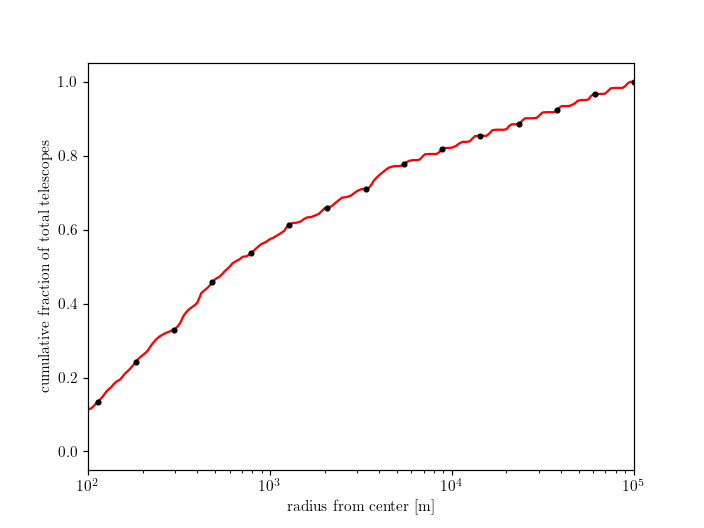

Text(0, 0.5, 'cumulative fraction of total telescopes')

In [315]:
plt.subplots()
plt.plot(x, y, 'r')
plt.plot(bins, hist, 'k.')

plt.xscale('log')
plt.xlim(1e2, 1e5)
plt.xlabel('radius from center [m]')
plt.ylabel('cumulative fraction of total telescopes')

<IPython.core.display.Javascript object>


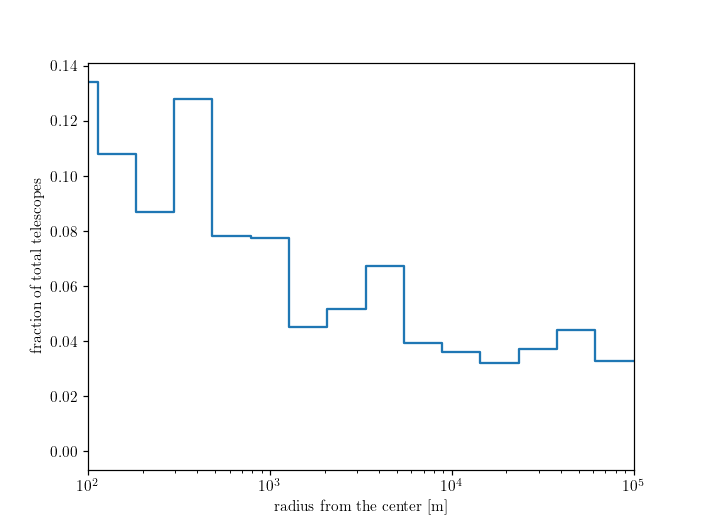

Text(0, 0.5, 'fraction of total telescopes')

In [308]:
plt.subplots()

plt.step(dist_r_arr, dist_frac_arr, where='pre')

plt.xscale('log')
plt.xlim(1e2, 1e5)
plt.xlabel('radius from the center [m]')
plt.ylabel('fraction of total telescopes')

<IPython.core.display.Javascript object>


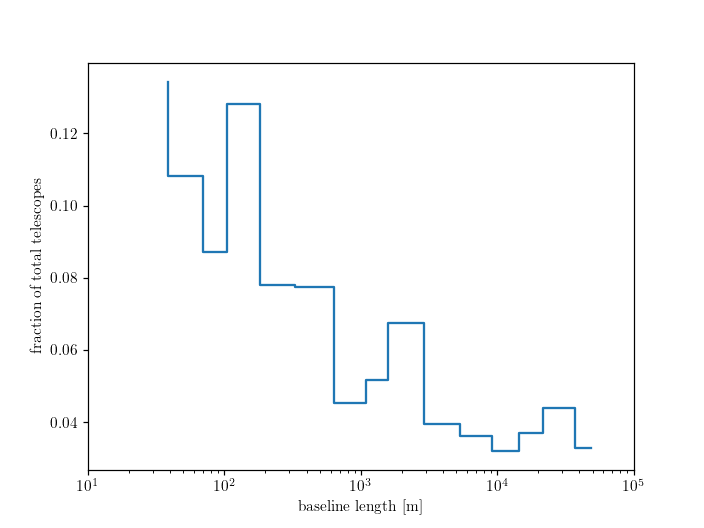

Text(0, 0.5, 'fraction of total telescopes')

In [310]:
plt.subplots()
plt.step(baseline_arr, dist_frac_arr, where='mid')

plt.xscale('log')
plt.xlim(1e1, 1e5)
plt.xlabel('baseline length [m]')
plt.ylabel('fraction of total telescopes')

<IPython.core.display.Javascript object>


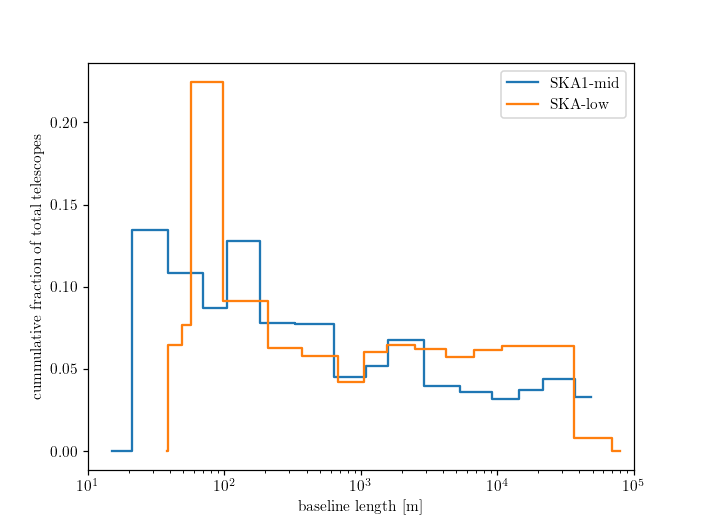

Text(0, 0.5, 'cummulative fraction of total telescopes')

In [7]:
plt.subplots()
#plt.step(ct.baseline_arr, np.cumsum(ct.dist_frac_arr), where='mid')
x, y = ct.SKA_conf['mid baseline distribution']
plt.step(x, y, where='mid', label='SKA1-mid')
x, y = ct.SKA_conf['low baseline distribution']
plt.step(x, y, where='mid', label='SKA-low')

plt.xscale('log')
plt.xlim(1e1, 1e5)
plt.legend(loc='best')
plt.xlabel('baseline length [m]')
plt.ylabel('cummulative fraction of total telescopes')

<IPython.core.display.Javascript object>


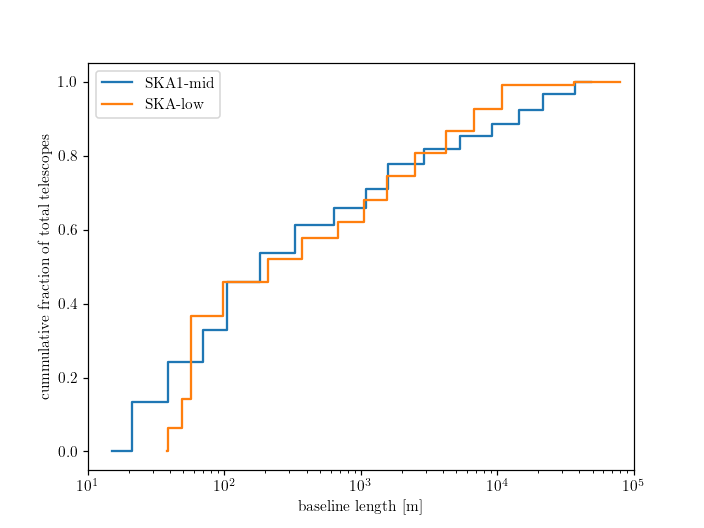

Text(0, 0.5, 'cummulative fraction of total telescopes')

In [10]:
plt.subplots()
#plt.step(ct.baseline_arr, np.cumsum(ct.dist_frac_arr), where='mid')
x, y = ct.SKA_conf['mid baseline cumulative']
plt.step(x, y, where='mid', label='SKA1-mid')
x, y = ct.SKA_conf['low baseline cumulative']
plt.step(x, y, where='mid', label='SKA-low')

plt.xscale('log')
plt.xlim(1e1, 1e5)
plt.legend(loc='best')
plt.xlabel('baseline length [m]')
plt.ylabel('cummulative fraction of total telescopes')
#plt.savefig('../plots/SKA_configuration.pdf')

/home/chen/Code/axion_laser/github/workspace_notebooks/../constants.py:51: RuntimeWarning: divide by zero encountered in true_divide
  B_eff = 2.*r / np.sqrt(number_of_tel)


<IPython.core.display.Javascript object>


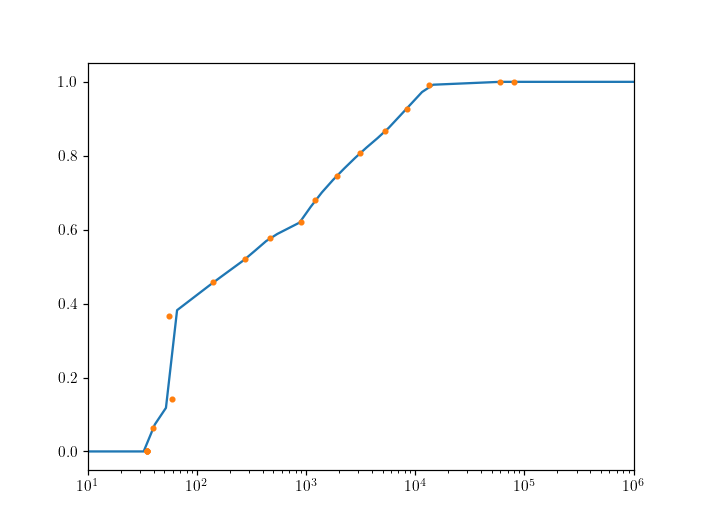

(10.0, 1000000.0)

In [407]:
# test the astro.SKA_get_active_baseline()
baseline_arr, cumu_frac_arr = ct.SKA_conf['low baseline cumulative']
r = np.logspace(1, 6)
active_baseline_arr = ap.SKA_get_active_baseline(r, exper_mode='SKA low')

plt.subplots()
plt.plot(r, active_baseline_arr)
plt.plot(baseline_arr, cumu_frac_arr, '.')
plt.xscale('log')
plt.xlim(1e1, 1e6)

<IPython.core.display.Javascript object>


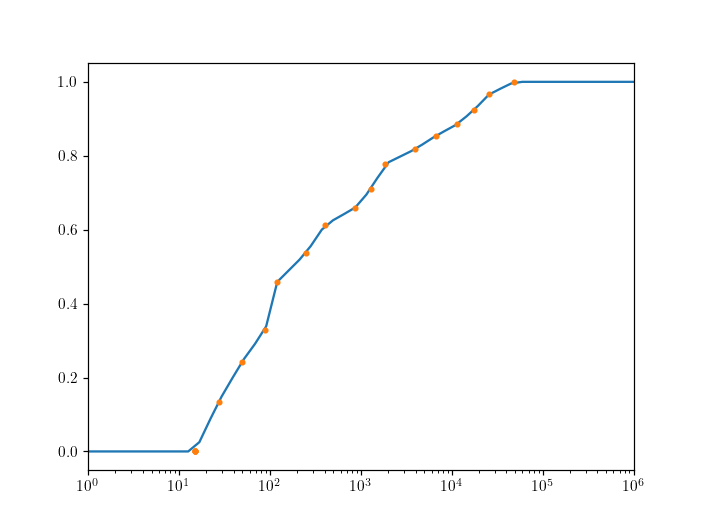

(1.0, 1000000.0)

In [408]:
# test the astro.SKA_get_active_baseline()
baseline_arr, cumu_frac_arr = ct.SKA_conf['mid baseline cumulative']
r = np.logspace(0, 6)
active_baseline_arr = ap.SKA_get_active_baseline(r, exper_mode='SKA mid')

plt.subplots()
plt.plot(r, active_baseline_arr)
plt.plot(baseline_arr, cumu_frac_arr, '.')
plt.xscale('log')
plt.xlim(1e0, 1e6)

In [432]:
ap.SKA_specs(0.05, exper_mode="SKA low", correlation_mode="interferometry", theta_sig=50)

(329011.52558907843,
 1.0,
 40.0,
 0.0001661422969897824,
 341.9677429009466,
 74159.28358270366)

In [438]:
x_arr = np.linspace(0.1, 6, 200)
fn = lambda x: np.sin(np.pi*x)/(np.pi*x)
fn3 = lambda x: np.sin(np.pi*x)
fn2 = lambda x: fn(x) - 0.3
plt.subplots()
plt.plot(x_arr, fn(x_arr))
#plt.plot(x_arr, fn3(x_arr))



/home/chen/Code/axion_laser/github/workspace_notebooks/../constants.py:51: RuntimeWarning: divide by zero encountered in true_divide
  B_eff = 2.*r / np.sqrt(number_of_tel)


<IPython.core.display.Javascript object>

In [429]:
from scipy.optimize import root_scalar
root_scalar(fn2, bracket=[0.1,1], method="bisect")

      converged: True
           flag: 'converged'
 function_calls: 41
     iterations: 39
           root: 0.7500785142090535

In [436]:
ap.P_noise(T_noise=100, 
           delnu=0.05e-3, 
           tobs=100, 
           Omega_obs=1.5e-4, 
           Omega_res=1e-3, 
           nu=0.05, 
           correlation_mode="single dish")

2.602750388039388e-16

In [437]:
ap.P_noise(T_noise=100, 
           delnu=0.05e-3, 
           tobs=100, 
           Omega_obs=1.5e-4, 
           Omega_res=None,
           nu=0.05, 
           correlation_mode="interferometry")

1.767430430075547e-17